## Imports, etc.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import datetime 
import os
import pandas as pd

from plotnine import *

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
pd.set_option('display.max_rows',500)

In [4]:
import snowflake.connector

conn = snowflake.connector.connect(
        user=os.environ["SNOWFLAKE_USER"],
        password=os.environ["SNOWFLAKE_PASSWORD"],
        account=os.environ["SNOWFLAKE_ACCOUNT"],
    )

In [5]:
def pq(qry,conn=conn):
    qry = qry.replace('from ','from predict.')
    return pd.read_sql(qry,conn)

## Basil

In [5]:
COMPONENT_ID = "15"

### 4/1/22 - 6/1/22

In [6]:
START_DATE = '2022-04-01'
END_DATE = '2022-06-01'

In [7]:
# Computed actuals
qry = f"""
    select * 
    from m_inflight_fulfillment
    where component_id = {COMPONENT_ID}
    and fact_date between '{START_DATE}' and '{END_DATE}'
    and is_latest_prediction = True
"""

computed_actuals = pq(qry)
computed_actuals.head(n=3)

,FARM_ID,FACT_DATE,REFERENCE_DATE,COMPONENT_ID,COMPONENT_NAME,CASE_INVENTORY_LBS,BIN_INVENTORY_LBS,RECENT_HARVEST_TO_PACK_PCT,BIN_INVENTORY_PACKED_ESTIMATION_LBS,PACKED_LBS,...,PREDICTED_SHORTFALL_LBS_Q90,SHORTFALL_PROBABILITY,COMPUTED_AT,COMPUTED_AT_LOCAL,PREDICTION_DAYS_AHEAD,CODE_VERSION,GIT_SHA,MESSAGE_ID,IS_WITHIN_BOUNDS,IS_LATEST_PREDICTION
0,0,2022-05-24,None,15,Basil,NaN,5.809185,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,None,None,None,None,True
1,0,2022-05-27,None,15,Basil,NaN,5.809185,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,None,None,None,None,True
2,2,2022-05-12,None,15,Basil,369.28125,270.064287,68.255484,184.333686,256.875,...,411.26,0.48,2022-05-12 23:16:06,2022-05-12 19:16:06,NaN,None,None,450bb8bd-1f22-5ae1-b610-e24a88996dec,True,True


In [9]:
qry = f"""
    with basil_formulations as (
        select formulation_id
        from warehouse.br_formulation_to_component
        where component_id = {COMPONENT_ID}
    ),
    sold_skus as (
        select distinct sku_id
        from warehouse.dm_line_items
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    ),
    sku_formulations as (
        select distinct sku_id, sku_name, formulation_id
        from warehouse.dm_skus
        inner join basil_formulations using (formulation_id)
    ),
    line_item_status as (
        select farm_id, 
          delivery_scheduled_on,
          weight_ordered_lbs,
          weight_allocated_lbs,
          (weight_ordered_lbs - weight_allocated_lbs) as shortfall
        from warehouse.dm_line_items
        inner join sku_formulations using (sku_id)
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    )
    select farm_id,
      delivery_scheduled_on,
      sum(shortfall) as shortfall_lbs
    from line_item_status
    group by farm_id, delivery_scheduled_on
"""

line_items_allocated_weight = pd.read_sql(qry,conn)

line_items_allocated_weight.head()

,FARM_ID,DELIVERY_SCHEDULED_ON,SHORTFALL_LBS
0,2,2022-04-20,0.0
1,2,2022-05-03,0.0
2,1,2022-05-23,0.0
3,2,2022-04-06,0.0
4,2,2022-04-25,0.0


/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 4 rows containing missing values.


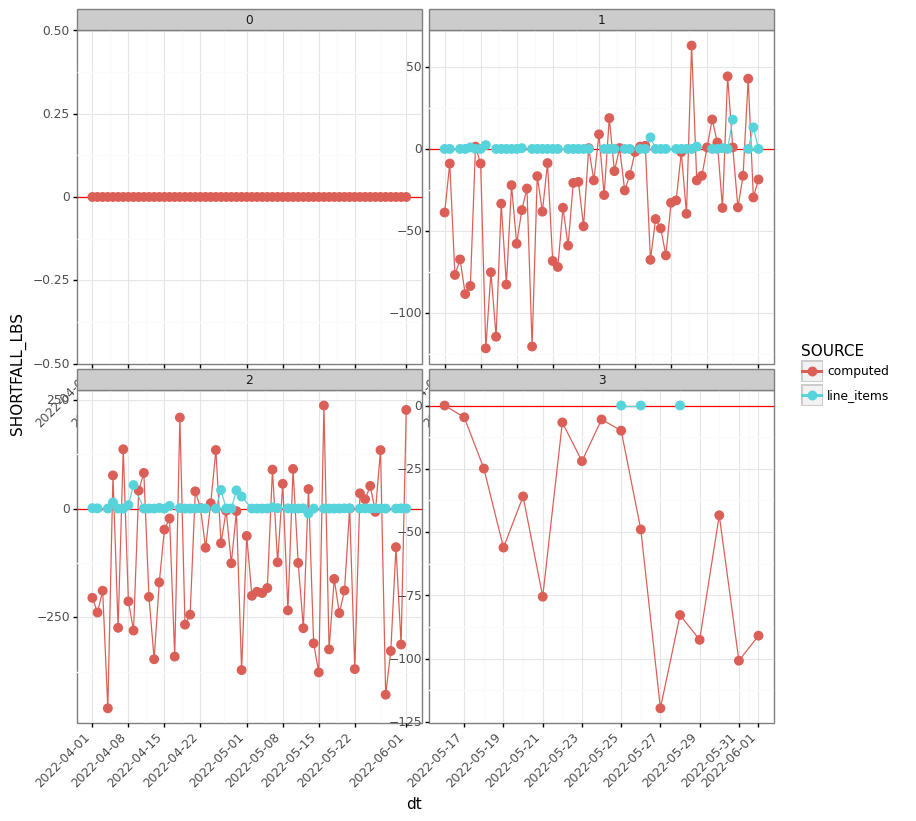

<ggplot: (359453871)>

In [11]:
(
    computed_actuals.filter(items=['FARM_ID','FACT_DATE','SHORTFALL_LBS'])
    .assign(SOURCE = 'computed')
    .pipe(lambda x: pd.concat([x,
                               line_items_allocated_weight.rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
                               .assign(SOURCE = 'line_items')],axis=0))
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .pipe(lambda frame: ggplot(frame, aes(x='dt',y='SHORTFALL_LBS',color='SOURCE'))
          + geom_hline(yintercept=0,color='red')
          + geom_line()
          + geom_point(size=3)
          + facet_wrap('FARM_ID', scales='free')
          + theme_bw()
          + theme(axis_text_x=element_text(hjust=1,rotation=45), figure_size=(9,9))
          
         )
)

### 1/1/21 - 12/13/21

In [180]:
START_DATE = '2021-01-01'
END_DATE = '2021-12-31'

In [181]:
# Computed actuals
qry = f"""
    select * 
    from predict_pmccarthy.m_inflight_fulfillment
    where component_id = {COMPONENT_ID}
    and fact_date between '{START_DATE}' and '{END_DATE}'
    and is_latest_prediction = True
"""

computed_actuals = pd.read_sql(qry,conn)
computed_actuals.head(n=3)

,FARM_ID,FACT_DATE,REFERENCE_DATE,COMPONENT_ID,COMPONENT_NAME,CASE_INVENTORY_LBS,BIN_INVENTORY_LBS,RECENT_HARVEST_TO_PACK_PCT,BIN_INVENTORY_PACKED_ESTIMATION_LBS,PACKED_LBS,...,PREDICTED_SHORTFALL_LBS_Q90,SHORTFALL_PROBABILITY,COMPUTED_AT,COMPUTED_AT_LOCAL,PREDICTION_DAYS_AHEAD,CODE_VERSION,GIT_SHA,MESSAGE_ID,IS_WITHIN_BOUNDS,IS_LATEST_PREDICTION
0,0,2021-07-08,None,15,Basil,NaN,5.809185,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,None,None,None,None,True
1,2,2021-10-10,None,15,Basil,297.1875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,None,None,None,None,True
2,0,2021-11-11,None,15,Basil,NaN,5.809185,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,None,None,None,None,True


In [182]:
computed_actuals.assign(dt = lambda x: pd.to_datetime(x['FACT_DATE'])).query("dt == '2021-09-01'").T

,88,109,402
FARM_ID,0,1,2
FACT_DATE,2021-09-01,2021-09-01,2021-09-01
REFERENCE_DATE,None,None,None
COMPONENT_ID,15,15,15
COMPONENT_NAME,Basil,Basil,Basil
CASE_INVENTORY_LBS,NaN,125.719,248.438
BIN_INVENTORY_LBS,5.80919,9.24619,NaN
RECENT_HARVEST_TO_PACK_PCT,NaN,87.6571,NaN
BIN_INVENTORY_PACKED_ESTIMATION_LBS,NaN,8.10495,NaN
PACKED_LBS,NaN,96.5625,NaN


In [183]:
qry = f"""
    with basil_formulations as (
        select formulation_id
        from warehouse.br_formulation_to_component
        where component_id = {COMPONENT_ID}
    ),
    sold_skus as (
        select distinct sku_id
        from warehouse.dm_line_items
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    ),
    sku_formulations as (
        select distinct sku_id, sku_name, formulation_id
        from warehouse.dm_skus
        inner join basil_formulations using (formulation_id)
    ),
    line_item_status as (
        select farm_id, 
          delivery_scheduled_on,
          weight_to_allocate_lbs,
          weight_allocated_lbs,
          (weight_ordered_lbs - weight_allocated_lbs) as shortfall
        from warehouse.dm_line_items
        inner join sku_formulations using (sku_id)
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
        and channel_category = 'primary'
        and order_status in ('shipped','delivered')
    )
    select farm_id,
      delivery_scheduled_on,
      sum(shortfall) as shortfall_lbs
    from line_item_status
    group by farm_id, delivery_scheduled_on
"""

line_items_allocated_weight = pd.read_sql(qry,conn)

line_items_allocated_weight.head()

,FARM_ID,DELIVERY_SCHEDULED_ON,SHORTFALL_LBS
0,2,2021-10-07,86.71875
1,1,2021-05-18,0.00000
2,2,2021-05-24,0.00000
3,1,2021-08-09,1.40625
4,2,2021-08-02,0.00000


/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 10 rows containing missing values.


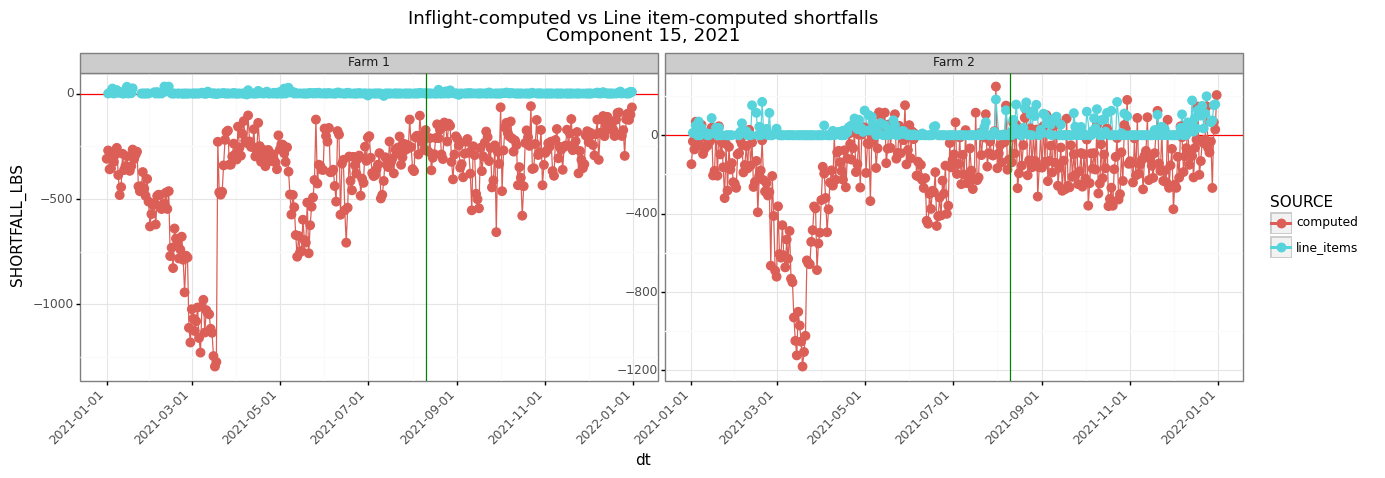

<ggplot: (366567370)>

In [184]:
(
    computed_actuals.filter(items=['FARM_ID','FACT_DATE','SHORTFALL_LBS'])
    .assign(SOURCE = 'computed')
    .pipe(lambda x: pd.concat([x,
                               line_items_allocated_weight.rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
                               .assign(SOURCE = 'line_items')],axis=0))
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .query('FARM_ID!=0')
#     .query('SHORTFALL_LBS >=1')
    .assign(farm_str = lambda x: "Farm " + x['FARM_ID'].astype(str))
    .pipe(lambda frame: ggplot(frame, aes(x='dt',y='SHORTFALL_LBS',color='SOURCE'))
          + geom_hline(yintercept=0,color='red')
          + geom_line()
          + geom_point(size=3)
          + facet_wrap('farm_str', scales='free')
          + theme_bw()
          + theme(axis_text_x=element_text(hjust=1,rotation=45), figure_size=(15,4))
          + geom_vline(xintercept=datetime.date(2021,8,10),color='green')
          + ggtitle(f"Inflight-computed vs Line item-computed shortfalls\nComponent {COMPONENT_ID}, 2021")
         )
)

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


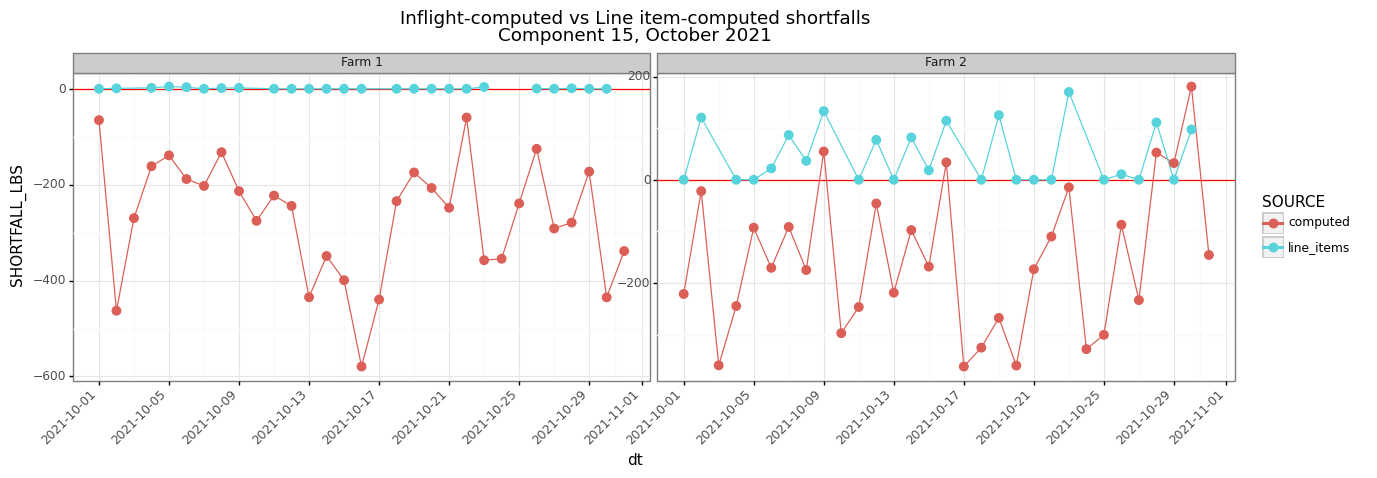

<ggplot: (366971606)>

In [188]:
(
    computed_actuals.filter(items=['FARM_ID','FACT_DATE','SHORTFALL_LBS'])
    .assign(SOURCE = 'computed')
    .pipe(lambda x: pd.concat([x,
                               line_items_allocated_weight.rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
                               .assign(SOURCE = 'line_items')],axis=0))
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .query('FARM_ID!=0')
#     .query('SHORTFALL_LBS >=1')
    .assign(farm_str = lambda x: "Farm " + x['FARM_ID'].astype(str))
    .query('dt < datetime.date(2021,11,1)')
    .query('dt > datetime.date(2021,9,30)')
    .pipe(lambda frame: ggplot(frame, aes(x='dt',y='SHORTFALL_LBS',color='SOURCE'))
          + geom_hline(yintercept=0,color='red')
          + geom_line()
          + geom_point(size=3)
          + facet_wrap('farm_str', scales='free')
          + theme_bw()
          + theme(axis_text_x=element_text(hjust=1,rotation=45), figure_size=(15,4))
          + ggtitle(f"Inflight-computed vs Line item-computed shortfalls\nComponent {COMPONENT_ID}, October 2021")
         )
)

In [203]:
## does this correspond to tranship activity?
COMPONENT_ID = 15
qry = f"""
    with basil_formulations as (
        select formulation_id
        from warehouse.br_formulation_to_component
        where component_id = {COMPONENT_ID}
    ),
    sold_skus as (
        select distinct sku_id
        from warehouse.dm_line_items
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    ),
    sku_formulations as (
        select distinct sku_id, sku_name, formulation_id
        from warehouse.dm_skus
        inner join basil_formulations using (formulation_id)
    ),
    line_items as (
        select l.*
        from warehouse.dm_line_items l
        inner join sku_formulations s using (sku_id)
        where delivery_scheduled_on between '2021-09-30' and '2021-11-01'
    ),
    cases as (
        select d.*, l.delivery_scheduled_on
        from warehouse.dm_cases d
        inner join line_items l using (order_id, sku_id)
    ),
    sums as (
        select farm_id,
          delivery_scheduled_on,
          sku_id,
          sum(case when source_farm_id <> farm_id then 1 else 0 end) as is_tranship,
          count(distinct case_id) as n_cases
        from cases 
        group by farm_id, delivery_scheduled_on, sku_id
    )
    select * from sums
"""
transship_sums = pd.read_sql(qry,conn)

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


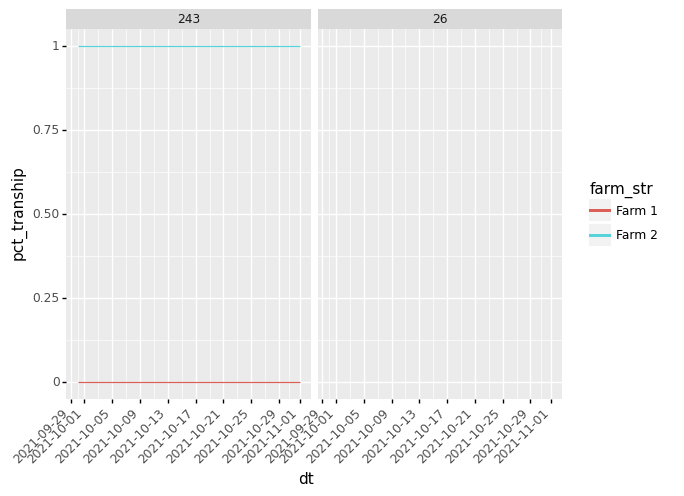

<ggplot: (368118083)>

In [204]:
(
    transship_sums
    .assign(dt = lambda x: pd.to_datetime(x['DELIVERY_SCHEDULED_ON']))
    .assign(farm_str = lambda x: "Farm "+x['FARM_ID'].astype(str))
    .assign(sku_str = lambda x: x['SKU_ID'].astype(str))
    .assign(pct_tranship = lambda x: x['IS_TRANSHIP']/x['N_CASES'])
    
    .pipe(lambda x: ggplot(x, aes(x='dt',y='pct_tranship',color='farm_str')) 
         + geom_line() 
         + theme(axis_text_x=element_text(hjust=1,rotation=45))
         + facet_wrap('sku_str'))
)

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


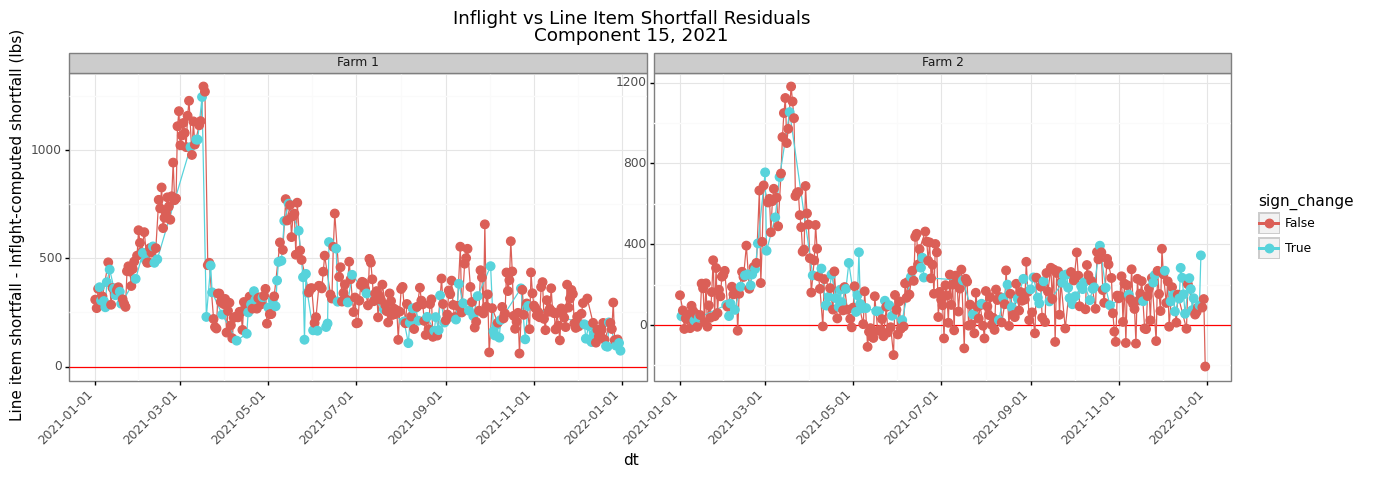

<ggplot: (366912500)>

In [185]:
(
    computed_actuals.filter(items=['FARM_ID','FACT_DATE','SHORTFALL_LBS'])
    .assign(SOURCE = 'computed')
    .query("FARM_ID != 0")
    .pipe(lambda x: pd.concat([x,
                               line_items_allocated_weight.rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
                               .assign(SOURCE = 'line_items')],axis=0))
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .pivot(index=['FARM_ID','dt'],columns=['SOURCE'],values=['SHORTFALL_LBS'])
    .fillna(0)
    .assign(residuals = lambda x: x['SHORTFALL_LBS']['line_items'] - x['SHORTFALL_LBS']['computed'])
    .assign(sign_change = lambda x: (
        ((x['SHORTFALL_LBS']['computed'] > 0) & (x['SHORTFALL_LBS']['line_items'] < 0)) |
        ((x['SHORTFALL_LBS']['computed'] < 0) & (x['SHORTFALL_LBS']['line_items'] > 0))
           )
           )
    .reset_index()
    .assign(farm_str = lambda x: "Farm " + x['FARM_ID'].astype(str))
    .pipe(lambda frame: ggplot(frame, aes(x='dt',y='residuals',color='sign_change'))
          + geom_hline(yintercept=0,color='red')
          + geom_line()
          + geom_point(size=3)
          + facet_wrap('farm_str', scales='free',ncol=2)
          + theme_bw()
          + theme(axis_text_x=element_text(hjust=1,rotation=45), figure_size=(15,4))
          + labs(y="Line item shortfall - Inflght-computed shortfall (lbs)")
          + ggtitle(f"Inflight vs Line Item Shortfall Residuals\nComponent {COMPONENT_ID}, 2021")
         )
)

In [53]:
def flatten_columns(df):
    df.columns = df.columns.get_level_values(0)
    return df

In [60]:
sign_change_residuals_f1 = (
    computed_actuals.filter(items=['FARM_ID','FACT_DATE','SHORTFALL_LBS'])
    .assign(SOURCE = 'computed')
    .query("FARM_ID != 0")
    .pipe(lambda x: pd.concat([x,
                               line_items_allocated_weight.rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
                               .assign(SOURCE = 'line_items')],axis=0))
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .pivot(index=['FARM_ID','dt'],columns=['SOURCE'],values=['SHORTFALL_LBS'])
    .fillna(0)
    .assign(residuals = lambda x: x['SHORTFALL_LBS']['line_items'] - x['SHORTFALL_LBS']['computed'])
    .assign(sign_change = lambda x: (
        ((x['SHORTFALL_LBS']['computed'] > 0) & (x['SHORTFALL_LBS']['line_items'] < 0)) |
        ((x['SHORTFALL_LBS']['computed'] < 0) & (x['SHORTFALL_LBS']['line_items'] > 0))
           )
           )
    .reset_index()
    .pipe(flatten_columns)
    .query('sign_change')
    .query('FARM_ID==1')
)

In [61]:
sign_change_residuals_f1.sort_values('residuals')

,FARM_ID,dt,SHORTFALL_LBS,SHORTFALL_LBS,residuals,sign_change
364,1,2021-12-31,-65.718750,7.50000,73.218750,True
355,1,2021-12-22,-89.625000,1.87500,91.500000,True
354,1,2021-12-21,-92.354509,1.87500,94.229509,True
361,1,2021-12-28,-95.501506,0.93750,96.439006,True
217,1,2021-08-06,-104.900193,3.28125,108.181443,True
...,...,...,...,...,...,...
134,1,2021-05-15,-752.415878,0.46875,752.884628,True
66,1,2021-03-08,-1010.312500,3.93750,1014.250000,True
71,1,2021-03-13,-1046.577373,2.25000,1048.827373,True
70,1,2021-03-12,-1040.072620,9.00000,1049.072620,True


## F1, 3/16

In [68]:
(
    computed_actuals
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .query('dt == datetime.date(2021,3,16)')
    .query("FARM_ID==1")
    .T
)

,820
FARM_ID,1
FACT_DATE,2021-03-16
REFERENCE_DATE,None
COMPONENT_ID,15
COMPONENT_NAME,Basil
CASE_INVENTORY_LBS,1129.75
BIN_INVENTORY_LBS,132.295
RECENT_HARVEST_TO_PACK_PCT,53.8335
BIN_INVENTORY_PACKED_ESTIMATION_LBS,71.2191
PACKED_LBS,95.625


In [75]:
THIS_DATE = '2021-03-16'
qry = f"""
    with basil_formulations as (
        select formulation_id
        from warehouse.br_formulation_to_component
        where component_id = {COMPONENT_ID}
    ),
    sold_skus as (
        select distinct sku_id
        from warehouse.dm_line_items
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    ),
    sku_formulations as (
        select distinct sku_id, sku_name, formulation_id
        from warehouse.dm_skus
        inner join basil_formulations using (formulation_id)
    ),
    line_item_status as (
        select li.*,
          (weight_ordered_lbs - weight_allocated_lbs) as shortfall
        from warehouse.dm_line_items li
        inner join sku_formulations f using (sku_id)
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    )
    select *
    from line_item_status
    where delivery_scheduled_on = '{THIS_DATE}'
    and farm_id = 1
"""

li_316 = pd.read_sql(qry,conn)

li_316.head()

,SKU_ID,FARM_ID,ORDER_ID,LINE_ITEM_ID,GS_ORDER_ID,GS_LINE_ITEM_ID,CUSTOMER_ID,CUSTOMER_LOCATION_ID,CUSTOMER_SKU_PROPERTY_ID,FORMULATION_FAMILY_ID,...,GTIN,UPC,GMO_CERTIFIED,IS_DEFAULT_FORMULATION,CASE_DIMENSIONS,STORAGE_LOCATION_ID,SHELF_LIFE_REQUIREMENT_DAYS,VALID_FROM,DATA_SOURCE,SHORTFALL
0,156,1,18980,65022,None,None,2,12,923,33,...,208-51536-00719-3,8-51536-00719-9,True,True,14 1/8 x 9 13/16 x 9 1/16,None,5,2021-03-17 21:00:02.437168,boweryos,0.0000
1,156,1,18946,64805,None,None,1,81,919,33,...,208-51536-00719-3,8-51536-00719-9,True,True,14 1/8 x 9 13/16 x 9 1/16,None,4,2021-03-24 20:11:54.531341,boweryos,0.0000
2,156,1,18951,64838,None,None,1,70,919,33,...,208-51536-00719-3,8-51536-00719-9,True,True,14 1/8 x 9 13/16 x 9 1/16,None,4,2021-03-24 20:26:30.188159,boweryos,0.0000
3,156,1,18937,64701,None,None,72,211,1190,33,...,208-51536-00719-3,8-51536-00719-9,True,True,14 1/8 x 9 13/16 x 9 1/16,None,5,2021-03-24 20:20:27.876757,boweryos,0.5625
4,156,1,18957,64883,None,None,1,7,919,33,...,208-51536-00719-3,8-51536-00719-9,True,True,14 1/8 x 9 13/16 x 9 1/16,None,4,2021-03-24 20:13:03.260987,boweryos,0.0000


In [84]:
li_316.query("SHORTFALL > 0").T

,3,14
SKU_ID,156,156
FARM_ID,1,1
ORDER_ID,18937,18953
LINE_ITEM_ID,64701,64853
GS_ORDER_ID,None,None
GS_LINE_ITEM_ID,None,None
CUSTOMER_ID,72,1
CUSTOMER_LOCATION_ID,211,162
CUSTOMER_SKU_PROPERTY_ID,1190,919
FORMULATION_FAMILY_ID,33,33


In [86]:
li_316['WEIGHT_ORDERED_LBS'].sum()

51.75

In [ ]:
# We projected a surplus of 1200lbs but a few pounds shortfall?

In [89]:
qry = """
select *
from report.f_daily_case_inventory_by_component
where component_id = 15
and fact_date between '2021-03-14' and '2021-03-18'
and farm_id = 1
order by fact_date
"""
case_inv_316 = pd.read_sql(qry,conn)

In [91]:
case_inv_316.T

,0,1,2,3,4
FACT_DATE,2021-03-14,2021-03-15,2021-03-16,2021-03-17,2021-03-18
FARM_ID,1,1,1,1,1
COMPONENT_ID,15,15,15,15,15
COMPONENT_NAME,Basil,Basil,Basil,Basil,Basil
COMMERCIAL_CATEGORY,Herbs,Herbs,Herbs,Herbs,Herbs
STARTING_INVENTORY_LBS,1065.62,1084.75,1129.75,1182.06,1195.38
INCOMING_INVENTORY_LBS,33.75,55.6875,95.625,59.0625,58.875
OUTGOING_INVENTORY_LBS,1.125,36.5625,50.625,6.75,45.5625
ENDING_INVENTORY_LBS,1065.62,1084.75,1129.75,1182.06,1195.38
CASE_PACKED_LBS,33.75,55.6875,95.625,59.0625,58.875


In [ ]:
## So we did have a lot of case inventory.

In [ ]:
## Was it a question of having the wrong sku?

In [92]:
li_316.groupby('SKU_ID')['WEIGHT_ORDERED_LBS'].sum()

SKU_ID
156    51.75
Name: WEIGHT_ORDERED_LBS, dtype: float64

In [99]:
li_316.groupby('SKU_ID')['CASES_ORDERED_COUNT'].sum()

SKU_ID
156    92.0
Name: CASES_ORDERED_COUNT, dtype: float64

In [97]:
qry = """
    select *
    from report.f_daily_case_inventory_by_sku
    where sku_id = 156
    and fact_date between '2021-03-14' and '2021-03-18'
    and farm_id = 1
"""
inv_sku_age_316 = pd.read_sql(qry,conn)

In [98]:
inv_sku_age_316.T

,0,1,2,3,4
FACT_DATE,2021-03-14,2021-03-15,2021-03-16,2021-03-17,2021-03-18
FARM_ID,1,1,1,1,1
SKU_ID,156,156,156,156,156
SKU_NAME,Basil (6 x 1.5oz clamshell),Basil (6 x 1.5oz clamshell),Basil (6 x 1.5oz clamshell),Basil (6 x 1.5oz clamshell),Basil (6 x 1.5oz clamshell)
FORMULATION_FAMILY_ID,33,33,33,33,33
FORMULATION_FAMILY_NAME,Basil,Basil,Basil,Basil,Basil
CASE_WEIGHT_LBS,0.5625,0.5625,0.5625,0.5625,0.5625
STARTING_INVENTORY_COUNT,998,1056,1090,1170,1263
INCOMING_INVENTORY_COUNT,60,99,170,105,94
OUTGOING_INVENTORY_COUNT,2,65,90,12,81


In [100]:
## I'm not sure why we had a shortfall this day, but it seems to have been trivial.

## Next

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


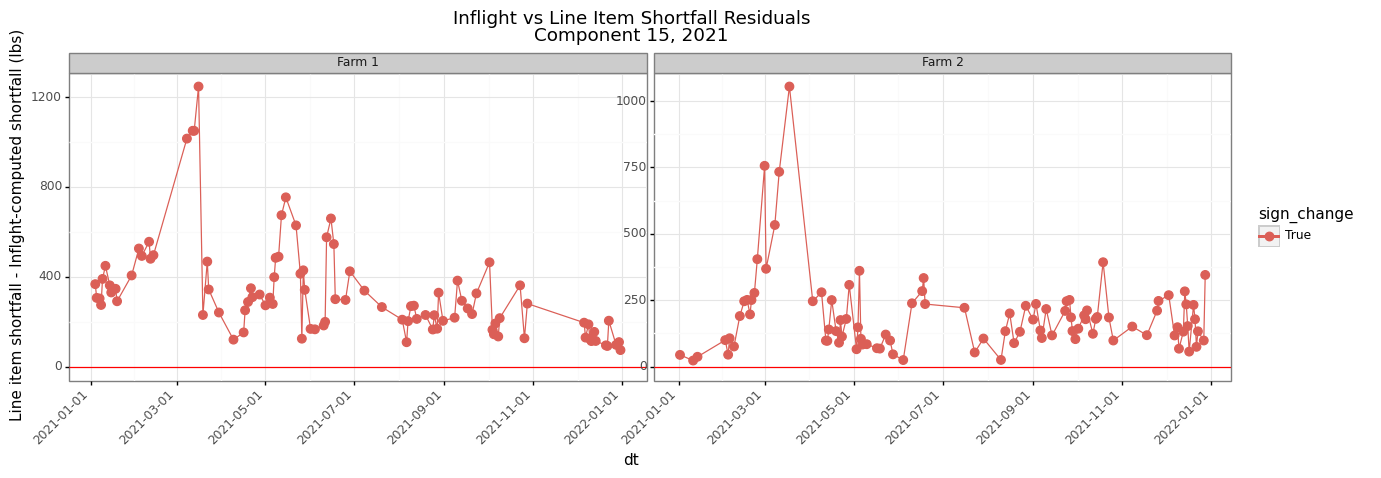

<ggplot: (365169857)>

In [111]:
(
    computed_actuals.filter(items=['FARM_ID','FACT_DATE','SHORTFALL_LBS'])
    .assign(SOURCE = 'computed')
    .query("FARM_ID != 0")
    .pipe(lambda x: pd.concat([x,
                               line_items_allocated_weight.rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
                               .assign(SOURCE = 'line_items')],axis=0))
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .pivot(index=['FARM_ID','dt'],columns=['SOURCE'],values=['SHORTFALL_LBS'])
    .fillna(0)
    .assign(residuals = lambda x: x['SHORTFALL_LBS']['line_items'] - x['SHORTFALL_LBS']['computed'])
    .assign(sign_change = lambda x: (
        ((x['SHORTFALL_LBS']['computed'] > 0) & (x['SHORTFALL_LBS']['line_items'] < 0)) |
        ((x['SHORTFALL_LBS']['computed'] < 0) & (x['SHORTFALL_LBS']['line_items'] > 0))
           )
           )
    .reset_index()
    .pipe(lambda x: x[x.sign_change==True])
    .assign(farm_str = lambda x: "Farm " + x['FARM_ID'].astype(str))
    .pipe(lambda frame: ggplot(frame, aes(x='dt',y='residuals',color='sign_change'))
          + geom_hline(yintercept=0,color='red')
          + geom_line()
          + geom_point(size=3)
          + facet_wrap('farm_str', scales='free',ncol=2)
          + theme_bw()
          + theme(axis_text_x=element_text(hjust=1,rotation=45), figure_size=(15,4))
          + labs(y="Line item shortfall - Inflght-computed shortfall (lbs)")
          + ggtitle(f"Inflight vs Line Item Shortfall Residuals\nComponent {COMPONENT_ID}, 2021")
         )
)

In [131]:
def new_columns(df):
    df.columns = ['FARM_ID','dt','SHORTFALL_COMPUTED','SHORTFALL_LINE_ITEMS','residuals','undetected_shortfall']
    return df

In [136]:
residuals = (
    computed_actuals.filter(items=['FARM_ID','FACT_DATE','SHORTFALL_LBS'])
    .assign(SOURCE = 'computed')
    .query("FARM_ID != 0")
    .pipe(lambda x: pd.concat([x,
                               line_items_allocated_weight.rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
                               .assign(SOURCE = 'line_items')],axis=0))
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .pivot(index=['FARM_ID','dt'],columns=['SOURCE'],values=['SHORTFALL_LBS'])
    .fillna(0)
    .assign(residuals = lambda x: x['SHORTFALL_LBS']['line_items'] - x['SHORTFALL_LBS']['computed'])
    .assign(undetected_shortfall = lambda x: (
        (x['SHORTFALL_LBS']['computed'] < 0) & 
            (x['SHORTFALL_LBS']['line_items'] > 0.01)
           ))
    .reset_index()
    .pipe(lambda x: x[x.undetected_shortfall == True])
#     .sort_values(['SHORTFALL_LBS']['line_items'])
    .pipe(flatten_columns)
    .pipe(new_columns)
    .sort_values('SHORTFALL_LINE_ITEMS',ascending=False)
#     .query('sign_change')
#     .query('FARM_ID==1')
)

In [137]:
residuals

,FARM_ID,dt,SHORTFALL_COMPUTED,SHORTFALL_LINE_ITEMS,residuals,undetected_shortfall
712,2,2021-12-14,-105.486682,177.65625,283.142932,True
414,2,2021-02-19,-25.773911,170.43750,196.211411,True
660,2,2021-10-23,-14.531250,170.15625,184.687500,True
407,2,2021-02-12,-37.083773,153.00000,190.083773,True
719,2,2021-12-21,-28.123868,150.00000,178.123868,True
656,2,2021-10-19,-267.656250,125.15625,392.812500,True
639,2,2021-10-02,-22.031250,120.46875,142.500000,True
410,2,2021-02-15,-131.124648,114.75000,245.874648,True
419,2,2021-02-24,-290.103852,114.18750,404.291352,True
630,2,2021-09-23,-96.562500,112.96875,209.531250,True


## F2 12/14

In [143]:
(
    computed_actuals
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .query('dt == datetime.date(2021,12,14)')
    .query("FARM_ID==2")
    .T
)

,735
FARM_ID,2
FACT_DATE,2021-12-14
REFERENCE_DATE,2021-12-01
COMPONENT_ID,15
COMPONENT_NAME,Basil
CASE_INVENTORY_LBS,181.406
BIN_INVENTORY_LBS,124.557
RECENT_HARVEST_TO_PACK_PCT,52.3248
BIN_INVENTORY_PACKED_ESTIMATION_LBS,65.1742
PACKED_LBS,83.4375


In [144]:
THIS_DATE = '2021-12-14'
FARM_ID = 2
qry = f"""
    with basil_formulations as (
        select formulation_id
        from warehouse.br_formulation_to_component
        where component_id = {COMPONENT_ID}
    ),
    sold_skus as (
        select distinct sku_id
        from warehouse.dm_line_items
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    ),
    sku_formulations as (
        select distinct sku_id, sku_name, formulation_id
        from warehouse.dm_skus
        inner join basil_formulations using (formulation_id)
    ),
    line_item_status as (
        select li.*,
          (weight_ordered_lbs - weight_allocated_lbs) as shortfall
        from warehouse.dm_line_items li
        inner join sku_formulations f using (sku_id)
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    )
    select *
    from line_item_status
    where delivery_scheduled_on = '{THIS_DATE}'
    and farm_id = {FARM_ID}
"""

li_1214 = pd.read_sql(qry,conn)

li_1214.head()

,SKU_ID,FARM_ID,ORDER_ID,LINE_ITEM_ID,GS_ORDER_ID,GS_LINE_ITEM_ID,CUSTOMER_ID,CUSTOMER_LOCATION_ID,CUSTOMER_SKU_PROPERTY_ID,FORMULATION_FAMILY_ID,...,GTIN,UPC,GMO_CERTIFIED,IS_DEFAULT_FORMULATION,CASE_DIMENSIONS,STORAGE_LOCATION_ID,SHELF_LIFE_REQUIREMENT_DAYS,VALID_FROM,DATA_SOURCE,SHORTFALL
0,243,2,26315,106619,None,None,61,209,1590,33,...,208-51536-00719-3,None,True,True,14 1/8 x 9 13/16 x 9 1/16,None,5,2021-12-14 21:12:38.760545,boweryos,0.0
1,243,2,26337,106761,None,None,81,256,1598,33,...,208-51536-00719-3,None,True,True,14 1/8 x 9 13/16 x 9 1/16,None,5,2021-12-14 21:11:52.978068,boweryos,0.0
2,243,2,26217,106028,None,None,8,89,1679,33,...,208-51536-00719-3,None,True,True,14 1/8 x 9 13/16 x 9 1/16,None,6,2021-12-15 21:16:17.919373,boweryos,NaN
3,243,2,26316,106629,None,None,61,210,1590,33,...,208-51536-00719-3,None,True,True,14 1/8 x 9 13/16 x 9 1/16,None,5,2021-12-14 21:12:20.290800,boweryos,0.0
4,243,2,26307,106464,None,None,3,14,1201,33,...,208-51536-00719-3,None,True,True,14 1/8 x 9 13/16 x 9 1/16,None,5,2021-12-15 21:16:44.097380,boweryos,NaN


In [150]:
li_1214.fillna(0).groupby(["CUSTOMER_ID",'SKU_ID','SHELF_LIFE_REQUIREMENT_DAYS'])[['WEIGHT_ALLOCATED_LBS','SHORTFALL']].sum()

,,,WEIGHT_ALLOCATED_LBS,SHORTFALL
CUSTOMER_ID,SKU_ID,SHELF_LIFE_REQUIREMENT_DAYS,,
3,243,5,0.0000,0.00000
8,243,6,0.0000,0.00000
53,243,4,28.1250,112.50000
57,243,5,12.1875,65.15625
59,243,5,2.8125,0.00000
61,243,5,2.8125,0.00000
81,243,5,0.9375,0.00000


In [ ]:
# 53 is albertsons, 57 is WFMA

In [151]:
li_1214.query("CUSTOMER_ID==53")

,SKU_ID,FARM_ID,ORDER_ID,LINE_ITEM_ID,GS_ORDER_ID,GS_LINE_ITEM_ID,CUSTOMER_ID,CUSTOMER_LOCATION_ID,CUSTOMER_SKU_PROPERTY_ID,FORMULATION_FAMILY_ID,...,GTIN,UPC,GMO_CERTIFIED,IS_DEFAULT_FORMULATION,CASE_DIMENSIONS,STORAGE_LOCATION_ID,SHELF_LIFE_REQUIREMENT_DAYS,VALID_FROM,DATA_SOURCE,SHORTFALL
5,243,2,24654,97592,None,None,53,236,1216,33,...,208-51536-00719-3,None,True,True,14 1/8 x 9 13/16 x 9 1/16,None,4,2021-12-14 21:10:42.049204,boweryos,112.5


In [155]:
li_1214.query("CUSTOMER_ID==53")['DELIVERY_SCHEDULED_ON']

5    2021-12-14
Name: DELIVERY_SCHEDULED_ON, dtype: object

In [152]:
qry = """
    select *
    from warehouse.dm_cases
    where sku_id = 243
    and order_id = 24654
"""
alb_cases = pd.read_sql(qry,conn)

In [154]:
alb_cases['CASE_ID'].nunique()

60

In [161]:
alb_cases.head()

,CASE_ID,FARM_ID,SOURCE_FARM_ID,PRODUCT_ID,SKU_ID,LINE_ITEM_ID,STORAGE_LOCATION_ID,PALLET_ID,LOT_NUMBER,UNIT_FORM_FACTOR,...,CLEARED_AT_LOCAL,PACKING_TASK_ID,PROCESSING_MACHINE_TYPES,IS_FROM_MANUAL_PACKING_TASK,IS_FROM_AUTO_FILL_PACKING_TASK,PACKING_TASK_COMPLETED_AT,PACKING_TASK_COMPLETED_AT_LOCAL,HOLD_PLACED_AT,HOLD_PLACED_AT_LOCAL,VALID_FROM
0,722296,2,2,None,243,97592,None,8363,25E239,clamshell,...,None,461148,None,None,None,2021-12-14 10:16:19.232175,2021-12-14 05:16:19.232175,None,None,2021-12-14 06:23:45.954428
1,722401,2,2,None,243,97592,None,8363,25E239,clamshell,...,None,461148,None,None,None,2021-12-14 10:16:19.232175,2021-12-14 05:16:19.232175,None,None,2021-12-14 06:23:41.362617
2,722295,2,2,None,243,97592,None,8363,25E239,clamshell,...,None,461148,None,None,None,2021-12-14 10:16:19.232175,2021-12-14 05:16:19.232175,None,None,2021-12-14 06:23:45.534985
3,722380,2,2,None,243,97592,None,8363,25E239,clamshell,...,None,461148,None,None,None,2021-12-14 10:16:19.232175,2021-12-14 05:16:19.232175,None,None,2021-12-14 06:23:42.161576
4,722208,2,2,None,243,97592,None,8363,25E239,clamshell,...,None,461148,None,None,None,2021-12-14 10:16:19.232175,2021-12-14 05:16:19.232175,None,None,2021-12-14 06:26:57.695874


In [160]:
alb_cases['SALABLE_MASS_LBS'].sum()

28.125

In [168]:
qry = """
select *
from report.f_hourly_case_inventory_by_sku_and_age
where sku_id = 243
and farm_id = 2
and hour_starting_at_local between '2021-12-13' and '2021-12-15'
"""
sku_and_age = pd.read_sql(qry,conn)
sku_and_age.head()

,HOUR_STARTING_AT,HOUR_STARTING_AT_LOCAL,FARM_ID,SKU_ID,SKU_NAME,FORMULATION_FAMILY_ID,FORMULATION_FAMILY_NAME,FORMULATION_ID,CASE_WEIGHT_LBS,AGE_HOURS,...,CASE_TRANSSHIPPED_INCOMING_COUNT,CASE_TRANSSHIPPED_OUTGOING_COUNT,CASE_QUALITY_LOSS_COUNT,CASE_OPERATIONAL_LOSS_COUNT,CASE_INTERNAL_USE_COUNT,CASE_MEASUREMENT_ERROR_COUNT,CASE_OTHER_COUNT,CASE_DONATED_COUNT,CASE_OFFLOAD_COUNT,CASE_PRIMARY_COUNT
0,2021-12-13 05:00:00,2021-12-13,2,243,Basil (6 x 1.25oz clamshell),33,Basil,33,0.46875,6,...,0,0,0,0,0,0,0,0,0,0
1,2021-12-13 05:00:00,2021-12-13,2,243,Basil (6 x 1.25oz clamshell),33,Basil,33,0.46875,7,...,0,0,0,0,0,0,0,0,0,0
2,2021-12-13 05:00:00,2021-12-13,2,243,Basil (6 x 1.25oz clamshell),33,Basil,33,0.46875,8,...,0,0,0,0,0,0,0,0,0,0
3,2021-12-13 05:00:00,2021-12-13,2,243,Basil (6 x 1.25oz clamshell),33,Basil,33,0.46875,9,...,0,0,0,0,0,0,0,0,0,0
4,2021-12-13 05:00:00,2021-12-13,2,243,Basil (6 x 1.25oz clamshell),33,Basil,33,0.46875,12,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# John suggested a miss like this could be saving inventory for a new client launch or other high importance order. 

In [217]:
SKU_IDs='243,26'
START_DATE = '2021-12-10'
END_DATE = '2021-12-25'

qry = f"""
with line_items as (
    select *, 
      weight_ordered_lbs - weight_allocated_lbs as shortfall
    from warehouse.dm_line_items
    where farm_id > 0
    and sku_id in ({SKU_IDs})
    and delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    and channel_category = 'primary'
    and order_status in ('shipped','delivered')
),
sums as (
    select farm_id,
      delivery_scheduled_on,
      customer_id,
      sum(weight_ordered_lbs) as weight_ordered_lbs,
      sum(weight_allocated_lbs) as weight_allocated_lbs,
      sum(shortfall) as shortfall
    from line_items
    group by farm_id,
      delivery_scheduled_on,
      customer_id
  )
select farm_id, 
  delivery_scheduled_on,
  customer_id, 
  weight_ordered_lbs,
  nvl(weight_allocated_lbs,0) as weight_allocated_lbs,
  (nvl(weight_allocated_lbs,0) / weight_ordered_lbs) as pct_fulfilled
from sums
"""

In [218]:
df = pd.read_sql(qry,conn)

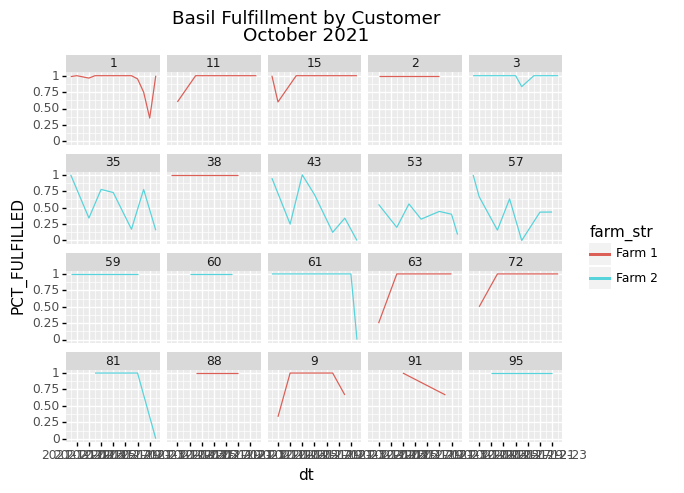

<ggplot: (369158202)>

In [222]:
(
    df
    .assign(dt = lambda x: pd.to_datetime(x['DELIVERY_SCHEDULED_ON']))
    .assign(farm_str = lambda x: 'Farm '+x['FARM_ID'].astype(str))
    .assign(customer_str = lambda x: x['CUSTOMER_ID'].astype(str))
    
    .pipe(lambda x: ggplot(x, aes(x='dt',y='PCT_FULFILLED', color='farm_str')) 
          + geom_line()
          + facet_wrap('customer_str')
          + ggtitle("Basil Fulfillment by Customer\nOctober 2021"))
)

In [ ]:
# 100% for much or all include: 
# +-----------+----------------------+
# |CUSTOMER_ID|CUSTOMER_NAME         |
# +-----------+----------------------+
# |88         |Mulberry Market       |
# |72         |MaxDelivery           |
# |38         |Shoprite              |
# |11         |Westside Market       |
# |60         |Dawson's              |
# |15         |Brooklyn Fare         |
# |95         |Foxtrot               |
# |2          |Foragers              |
# |63         |Avo Now               |
# |61         |Graul's Market        |
# |59         |Eddie's of Roland Park|
# +-----------+----------------------+



# Kale

In [6]:
## does this correspond to tranship activity?
COMPONENT_ID = 4
START_DATE = '2021-05-1'
END_DATE = '2021-09-01'
qry = f"""
    with basil_formulations as (
        select formulation_id
        from warehouse.br_formulation_to_component
        where component_id = {COMPONENT_ID}
    ),
    sold_skus as (
        select distinct sku_id
        from warehouse.dm_line_items
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    ),
    sku_formulations as (
        select distinct sku_id, sku_name, formulation_id
        from warehouse.dm_skus
        inner join basil_formulations using (formulation_id)
    ),
    line_items as (
        select l.*
        from warehouse.dm_line_items l
        inner join sku_formulations s using (sku_id)
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    ),
    cases as (
        select d.*, l.delivery_scheduled_on
        from warehouse.dm_cases d
        inner join line_items l using (order_id, sku_id)
    ),
    sums as (
        select farm_id,
          delivery_scheduled_on,
          sku_id,
          sum(case when source_farm_id <> farm_id then 1 else 0 end) as is_tranship,
          count(distinct case_id) as n_cases
        from cases 
        group by farm_id, delivery_scheduled_on, sku_id
    )
    select * from sums
"""
transship_sums = pd.read_sql(qry,conn)

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


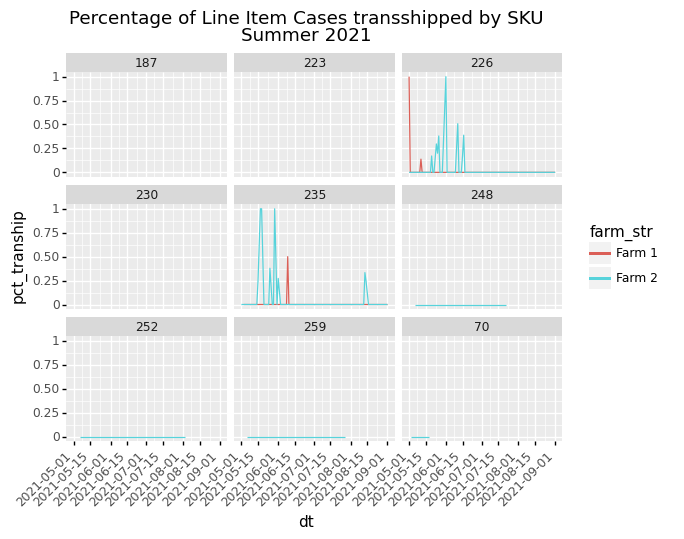

<ggplot: (355268322)>

In [8]:
(
    transship_sums
    .assign(dt = lambda x: pd.to_datetime(x['DELIVERY_SCHEDULED_ON']))
    .assign(farm_str = lambda x: "Farm "+x['FARM_ID'].astype(str))
    .assign(sku_str = lambda x: x['SKU_ID'].astype(str))
    .assign(pct_tranship = lambda x: x['IS_TRANSHIP']/x['N_CASES'])
    
    .pipe(lambda x: ggplot(x, aes(x='dt',y='pct_tranship',color='farm_str')) 
         + geom_line() 
         + theme(axis_text_x=element_text(hjust=1,rotation=45))
         + facet_wrap('sku_str')
         + ggtitle("Percentage of Line Item Cases transshipped by SKU\nSummer 2021"))
)

In [9]:
START_DATE = '2021-01-01'
END_DATE = '2021-12-31'

In [10]:
# Computed actuals
COMPONENT_ID = 4
qry = f"""
    select * 
    from predict_pmccarthy.m_inflight_fulfillment
    where component_id = {COMPONENT_ID}
    and fact_date between '{START_DATE}' and '{END_DATE}'
    and is_latest_prediction = True
"""

computed_actuals = pd.read_sql(qry,conn)
computed_actuals.head(n=3)

,FARM_ID,FACT_DATE,REFERENCE_DATE,COMPONENT_ID,COMPONENT_NAME,CASE_INVENTORY_LBS,BIN_INVENTORY_LBS,RECENT_HARVEST_TO_PACK_PCT,BIN_INVENTORY_PACKED_ESTIMATION_LBS,PACKED_LBS,...,PREDICTED_SHORTFALL_LBS_Q90,SHORTFALL_PROBABILITY,COMPUTED_AT,COMPUTED_AT_LOCAL,PREDICTION_DAYS_AHEAD,CODE_VERSION,GIT_SHA,MESSAGE_ID,IS_WITHIN_BOUNDS,IS_LATEST_PREDICTION
0,2,2021-05-13,None,4,Baby Kale,107.0550,73.350794,68.931613,50.561885,23.861491,...,NaN,NaN,NaT,NaT,NaN,None,None,None,None,True
1,1,2021-11-29,None,4,Baby Kale,594.6975,33.391241,87.203548,29.118347,28.500000,...,NaN,NaN,NaT,NaT,NaN,None,None,None,None,True
2,2,2021-11-27,None,4,Baby Kale,584.1900,153.746098,84.692258,130.211042,234.534886,...,NaN,NaN,NaT,NaT,NaN,None,None,None,None,True


In [11]:
computed_actuals.assign(dt = lambda x: pd.to_datetime(x['FACT_DATE'])).query("dt == '2021-09-01'").T

,461,695
FARM_ID,2,1
FACT_DATE,2021-09-01,2021-09-01
REFERENCE_DATE,None,None
COMPONENT_ID,4,4
COMPONENT_NAME,Baby Kale,Baby Kale
CASE_INVENTORY_LBS,846.42,174.293
BIN_INVENTORY_LBS,183.253,31.654
RECENT_HARVEST_TO_PACK_PCT,80.7777,81.7881
BIN_INVENTORY_PACKED_ESTIMATION_LBS,148.028,25.8892
PACKED_LBS,273.361,28.3025


In [12]:
qry = f"""
    with formulations as (
        select formulation_id
        from warehouse.br_formulation_to_component
        where component_id = {COMPONENT_ID}
    ),
    sold_skus as (
        select distinct sku_id
        from warehouse.dm_line_items
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    ),
    sku_formulations as (
        select distinct sku_id, sku_name, formulation_id
        from warehouse.dm_skus
        inner join formulations using (formulation_id)
    ),
    line_item_status as (
        select farm_id, 
          delivery_scheduled_on,
          weight_to_allocate_lbs,
          weight_allocated_lbs,
          (weight_ordered_lbs - weight_allocated_lbs) as shortfall
        from warehouse.dm_line_items
        inner join sku_formulations using (sku_id)
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
        and channel_category = 'primary'
        and order_status in ('shipped','delivered')
    )
    select farm_id,
      delivery_scheduled_on,
      sum(shortfall) as shortfall_lbs
    from line_item_status
    group by farm_id, delivery_scheduled_on
"""

line_items_allocated_weight = pd.read_sql(qry,conn)

line_items_allocated_weight.head()

,FARM_ID,DELIVERY_SCHEDULED_ON,SHORTFALL_LBS
0,2,2021-05-24,6.0
1,2,2021-10-07,0.0
2,1,2021-08-09,0.0
3,1,2021-05-18,4.5
4,2,2021-08-02,0.0


/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 3 rows containing missing values.


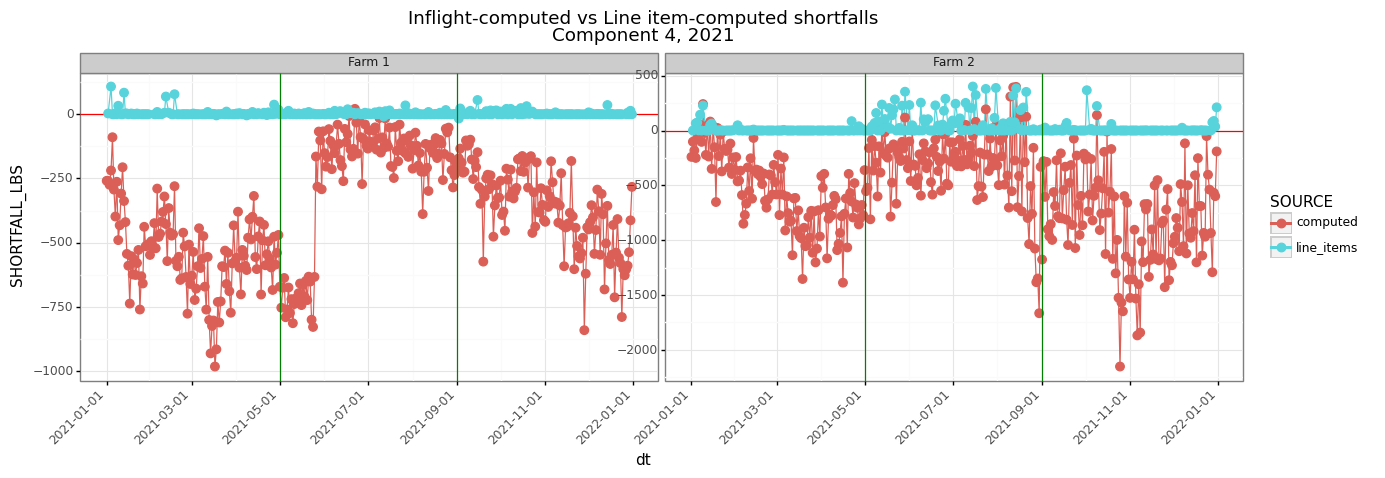

<ggplot: (355659530)>

In [13]:
(
    computed_actuals.filter(items=['FARM_ID','FACT_DATE','SHORTFALL_LBS'])
    .assign(SOURCE = 'computed')
    .pipe(lambda x: pd.concat([x,
                               line_items_allocated_weight.rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
                               .assign(SOURCE = 'line_items')],axis=0))
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .query('FARM_ID!=0')
#     .query('SHORTFALL_LBS >=1')
    .assign(farm_str = lambda x: "Farm " + x['FARM_ID'].astype(str))
    .pipe(lambda frame: ggplot(frame, aes(x='dt',y='SHORTFALL_LBS',color='SOURCE'))
          + geom_hline(yintercept=0,color='red')
          + geom_line()
          + geom_point(size=3)
          + facet_wrap('farm_str', scales='free')
          + theme_bw()
          + theme(axis_text_x=element_text(hjust=1,rotation=45), figure_size=(15,4))
          + geom_vline(xintercept=datetime.date(2021,5,1),color='green')
          + geom_vline(xintercept=datetime.date(2021,9,1),color='green')
          + ggtitle(f"Inflight-computed vs Line item-computed shortfalls\nComponent {COMPONENT_ID}, 2021")
         )
)

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 204 rows containing missing values.
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 885 rows containing missing values.


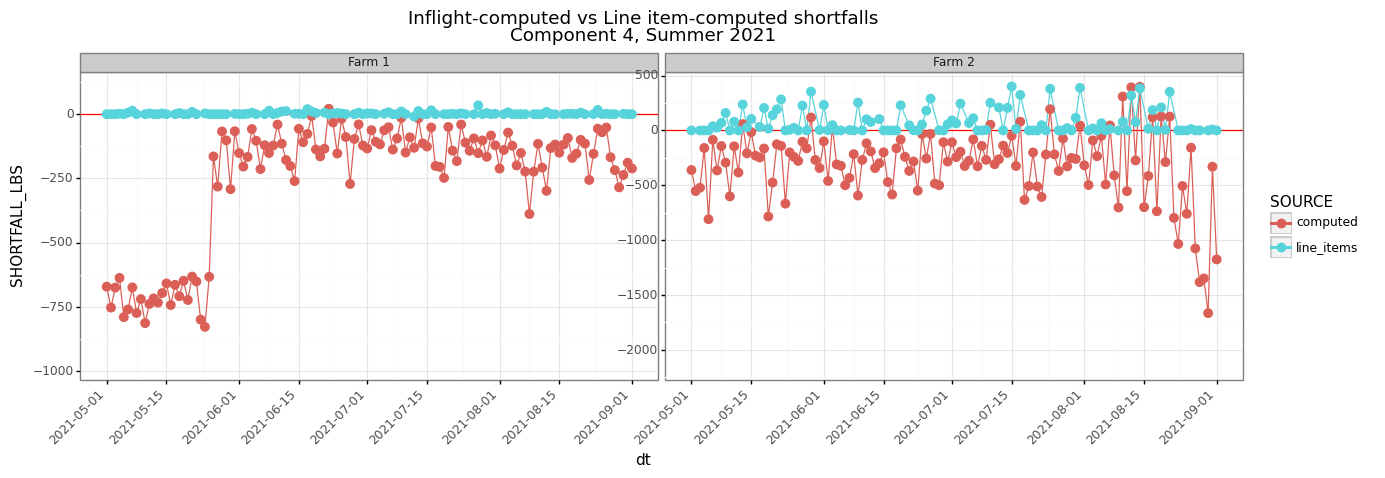

<ggplot: (355765206)>

In [14]:
(
    computed_actuals.filter(items=['FARM_ID','FACT_DATE','SHORTFALL_LBS'])
    .assign(SOURCE = 'computed')
    .pipe(lambda x: pd.concat([x,
                               line_items_allocated_weight.rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
                               .assign(SOURCE = 'line_items')],axis=0))
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .query('FARM_ID!=0')
#     .query('SHORTFALL_LBS >=1')
    .assign(farm_str = lambda x: "Farm " + x['FARM_ID'].astype(str))
    .pipe(lambda frame: ggplot(frame, aes(x='dt',y='SHORTFALL_LBS',color='SOURCE'))
          + geom_hline(yintercept=0,color='red')
          + geom_line()
          + geom_point(size=3)
          + facet_wrap('farm_str', scales='free')
          + theme_bw()
          + theme(axis_text_x=element_text(hjust=1,rotation=45), figure_size=(15,4))
#           + geom_vline(xintercept=datetime.date(2021,8,10),color='green')
          + scale_x_date(limits=[datetime.date(2021,5,1),datetime.date(2021,9,1)])
          + ggtitle(f"Inflight-computed vs Line item-computed shortfalls\nComponent {COMPONENT_ID}, Summer 2021")
         )
)

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


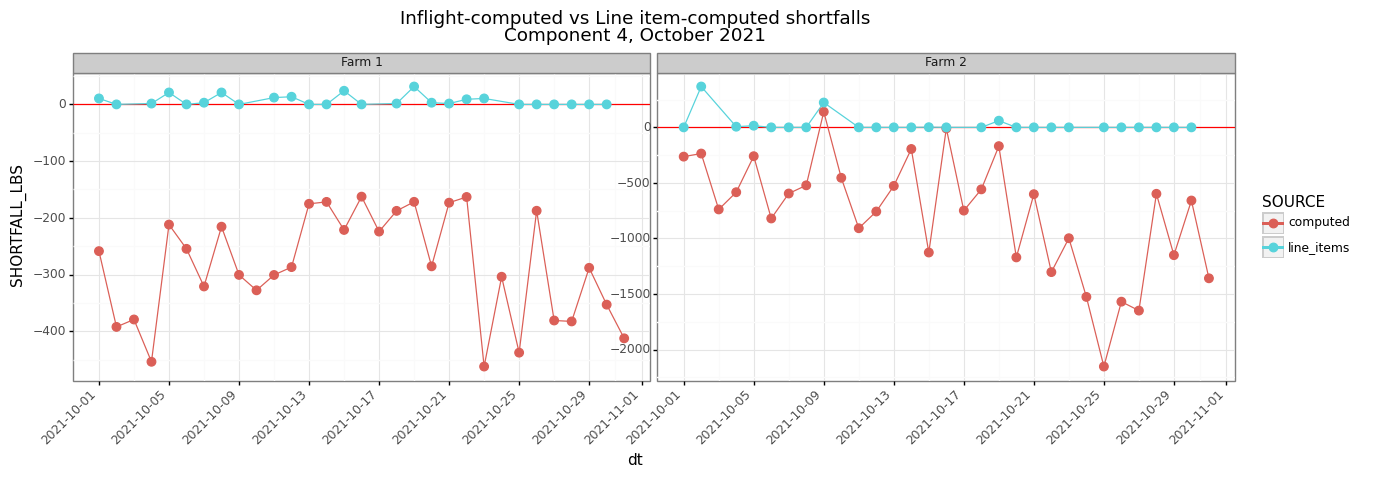

<ggplot: (355663924)>

In [15]:
(
    computed_actuals.filter(items=['FARM_ID','FACT_DATE','SHORTFALL_LBS'])
    .assign(SOURCE = 'computed')
    .pipe(lambda x: pd.concat([x,
                               line_items_allocated_weight.rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
                               .assign(SOURCE = 'line_items')],axis=0))
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .query('FARM_ID!=0')
#     .query('SHORTFALL_LBS >=1')
    .assign(farm_str = lambda x: "Farm " + x['FARM_ID'].astype(str))
    .query('dt < datetime.date(2021,11,1)')
    .query('dt > datetime.date(2021,9,30)')
    .pipe(lambda frame: ggplot(frame, aes(x='dt',y='SHORTFALL_LBS',color='SOURCE'))
          + geom_hline(yintercept=0,color='red')
          + geom_line()
          + geom_point(size=3)
          + facet_wrap('farm_str', scales='free')
          + theme_bw()
          + theme(axis_text_x=element_text(hjust=1,rotation=45), figure_size=(15,4))
          + ggtitle(f"Inflight-computed vs Line item-computed shortfalls\nComponent {COMPONENT_ID}, October 2021")
         )
)